### Notebook for an example Coronal Model Evaluation full cycle

In [11]:
from CHmetric import CHmetric,ezseg
from WLmetric import WLmetric
from NLmetric import NLmetric

from CHMAP import chmap

import datetime
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map

In [5]:
euvmappath = CHmetric.create_euv_map(datetime.datetime(2018,11,6))

In [6]:
euvmap = sunpy.map.Map(euvmappath)

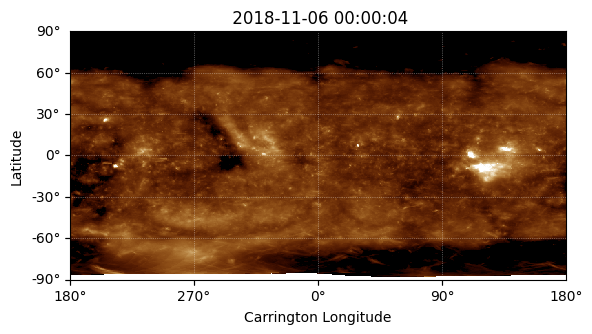

In [7]:
euvmap.plot(cmap="sdoaia193",
            vmin=np.nanpercentile(euvmap.data.flatten(),20),
            vmax=np.nanpercentile(euvmap.data.flatten(),99.9)
           )

In [26]:
euvmap_array= euvmap.data
valid_data = ~np.isnan(euvmap_array)

### Parameters for EZSEG 
thresh1 = 50 ## Seed threshold
thresh2 = 100 ## Growing Threshhold
nc = 7 ## at least 7 consecutive pixels to declare coronal hole area is connected
iters = 100 # Do maximum 100 iterations
### 

## Python version via D. H. Brooks
segmented_array = ezseg.ezseg_algorithm(euvmap_array, ## Data to extract contours from
                                        valid_data, ## Valid pixels
                                        euvmap_array.shape[0], ## x-dimension of array
                                        euvmap_array.shape[1], ## y-dimension of array
                                        thresh1,thresh2,nc,iters ## EZSEG input params defined above
                                       )

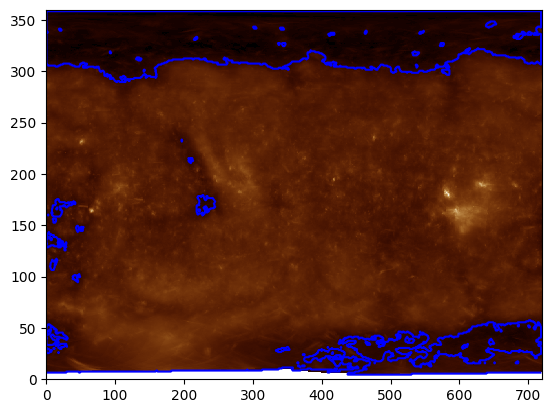

In [27]:
plt.pcolormesh(euvmap_array,cmap="sdoaia193")
plt.contour(segmented_array,[0.5],colors=["blue"])